In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import time
import jax.numpy as jnp
import jax
import jax.lax as lax
from jax import grad, jit, vmap
from jax import random
from functools import partial
import cvxpy as cp
from cvxpylayers.jax import CvxpyLayer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Genearate Dataset
def generate_data(A_true, B_true, T, i, sigma_u = 1.0, sigma_w = 1.0):
  n, p = A_true.shape[0], B_true.shape[1]
  Theta = jnp.zeros((n+p, n))
  Theta = Theta.at[:n, :].set(A_true.T)
  Theta = Theta.at[n:, :].set(B_true.T)

  X = jnp.zeros((T, n))
  Z = jnp.zeros((T, n+p))

  base_key = random.PRNGKey(i)
  key_sequence = random.split(base_key, T + 1)
  Z = Z.at[0, n:].set(random.normal(key_sequence[0], shape=(p,)) * sigma_u)
  W = random.normal(key_sequence[1], shape=(T, n)) * sigma_w

  for t in range(T):
    X = X.at[t, :].set(Z[t, :] @ Theta + W[t, :])
    if t != T-1:
      Z = Z.at[t+1, :n].set(X[t, :])
      Z = Z.at[t+1, n:].set(random.normal(key_sequence[t+2], shape=(p,)) * sigma_u)
  # print("X", X)
  # print("Z", Z)
  # print("W", W)
  return X, Z, W

# Least Square Estimator
def lse(A_true, B_true, T, N, j, sigma_u = 1.0, sigma_w = 1.0):
  error = []
  theta = []
  FI = []
  Zn = jnp.zeros((N, T, A_true.shape[0] + B_true.shape[1]))
  Xn = jnp.zeros((N, T, A_true.shape[0]))
  Wn = jnp.zeros((N, T, A_true.shape[0]))
  for i in range(N):
    Xi, Zi, Wi = generate_data(A_true, B_true, T, i*(j+1), sigma_u, sigma_w)
    # print("Xi", Xi)
    # print("Zi", Zi)
    # print("Wi", Wi)
    Xn = Xn.at[i, :, :].set(Xi)
    Zn = Zn.at[i, :, :].set(Zi)
    Wn = Wn.at[i, :, :].set(Wi)
    Z_flat = Zn[:i+1, :, :].reshape(-1, Zn.shape[-1])
    X_flat = Xn[:i+1, :, :].reshape(-1, Xn.shape[-1])
    W_flat = Wn[:i+1, :, :].reshape(-1, Wn.shape[-1])
    E = jnp.linalg.inv(Z_flat.T @ Z_flat) @ Z_flat.T @ W_flat
    theta_hat = jnp.linalg.inv(Z_flat.T @ Z_flat) @ Z_flat.T @ X_flat
    error.append(jnp.linalg.norm(E))
    theta.append(theta_hat)

    # calculate Fisher Information Matrix
    outer_product = jnp.einsum('ni, nj->nij', Z_flat, Z_flat) # shape (-1, 6, 6)
    FI_element = jnp.kron(outer_product, (1/sigma_w)*jnp.eye(A_true.shape[0]))
    FI_element = jnp.sum(FI_element, axis = 0)
    FI.append(FI_element)

  return error, jnp.asarray(theta), jnp.asarray(FI)

In [ ]:
@jit
def LQR(A, B, Q, R):

  # P = scipy.linalg.solve_discrete_are(A, B, Q, R)
  P = dare_jax(A, B, Q, R)

  P = jnp.array(P)

  try:
    K = -jnp.linalg.inv(B.T@P@B +R) @ B.T @ P @ A   # discrete case
  except:
    K = jnp.zeros_like(B)
  return K

def dare_host(A, B, Q, R):
  # call a scipy operation:
  try:
    return scipy.linalg.solve_discrete_are(A, B, Q, R).astype(A.dtype)
  except:
    return jnp.zeros_like(A).astype(A.dtype)

# JAX-compatible wrapper for scipy.linalg.solve_discrete_are(A, B, Q, R)
@jit
def dare_jax(A, B, Q, R):
  result_shape = jax.ShapeDtypeStruct(A.shape, A.dtype)
  return jax.pure_callback(dare_host, result_shape, A, B, Q, R)

@jit
def Lyapunov(A, B, K, Q, R):

  # P = scipy.linalg.solve_discrete_lyapunov((A + B @ K).T, Q + K.T @ R @ K)
  P = dlyap_direct((A + B @ K).T, Q + K.T @ R @ K)
  return P

def eigvals_host(A, B):
  # call a scipy operation:
  return scipy.linalg.eigvals(A + B).astype(A.dtype)

def eigvals_jax(A, B):
  '''
    JAX-compatible wrapper for scipy.linalg.eigvals(A, B)
  '''
  return jnp.linalg.eigvals(A + B)

  # result_shape = jax.ShapeDtypeStruct((A.shape[0],), A.dtype)
  # return jax.pure_callback(eigvals_host, result_shape, A, B)

In [ ]:
def controller(A_hat, B_hat, A_true, B_true, Q, R):
  K_hat = LQR(A_hat, B_hat, Q, R)
  K_true = LQR(A_true, B_true, Q, R)

  def true_fn(_):
    P_hat = Lyapunov(A_true, B_true, K_hat, Q, R)
    return jnp.trace(P_hat)

  def false_fn(_):
    return 1000000.

  eigvals_product = jnp.max(jnp.abs(eigvals_jax(A_true, B_true) @ K_hat))
  J_hat = jax.lax.cond(eigvals_product < 1, true_fn, false_fn, None)

  P_true = Lyapunov(A_true, B_true, K_true, Q, R)
  J_true = jnp.trace(P_true)

  J_error = J_hat - J_true
  return J_error

In [ ]:
def eval_controller(K_eval, A_true, B_true, Q, R):
  K_true = LQR(A_true, B_true, Q, R)

  def true_fn(_):
    P_hat = Lyapunov(A_true, B_true, K_eval, Q, R)
    return jnp.trace(P_hat)

  def false_fn(_):
    return 1000000.

  eigvals_product = jnp.max(jnp.abs(eigvals_jax(A_true, B_true @ K_eval)))
  J_hat = jax.lax.cond(eigvals_product < 1, true_fn, false_fn, None)

  P_true = Lyapunov(A_true, B_true, K_true, Q, R)
  J_true = jnp.trace(P_true)

  J_error = J_hat - J_true
  return J_error

In [ ]:
@jit
def randomController(A, B, Q, R, sigma_w, M, eta, K, FI, j, N):
    """
    Domain Randomization for Linear Systems
    M: number of SGD iterations
    eta: learning rate
    epsilon: sample range
    """
    dx = A.shape[0]
    I3 = sigma_w * jnp.eye(dx)

    def loop_body(i, carry):
        K, P, Sigma = carry
        key = random.PRNGKey(i*(j+1))
        key, subkey = random.split(key)
        A_sample, B_sample = sample_uniform_from_ball(A, B, FI, subkey, N)

        def true_fn(K, P, Sigma):
          R_plus_BtPB = R + B_sample.T @ P @ B_sample
          BtPA = B_sample.T @ P @ A_sample

          K = K - (eta / jnp.sqrt(i + 1)) * 2 * (R_plus_BtPB @ K + BtPA) @ Sigma
          P = gradientLyapunov(A_sample, B_sample, K, Q, R)
          Sigma = SigmaLyapunov(A_sample, B_sample, K, I3)
          return K, P, Sigma

        def false_fn(K, P, Sigma):
          return K, P, Sigma

        eigvals_product = jnp.max(jnp.abs(eigvals_jax(A_sample, B_sample @ K)))
        K, P, Sigma = jax.lax.cond(eigvals_product < 1, true_fn, false_fn, K, P, Sigma)

        return K, P, Sigma

    P = gradientLyapunov(A, B, K, Q, R)
    Sigma = SigmaLyapunov(A, B, K, I3)
    K, P, Sigma = jax.lax.fori_loop(0, M, loop_body, (K, P, Sigma))

    return K

@jit
def gradientLyapunov(A, B, K, Q, R):
    return dlyap_direct((A + B @ K).T, (Q + K.T @ R @ K))

@jit
def SigmaLyapunov(A, B, K, sigma_w_eye):
    return dlyap_direct((A + B @ K), sigma_w_eye)

@jit
def sampleUniform(A, B, eps, key):
    n, p = A.shape[0], B.shape[1]
    sample = 2 * eps * random.uniform(key, (n+p, n)) - eps

    return A + sample[:n, :], B + sample[n:, :]

@jit
def dlyap_direct(A, Q):
    def true_fn(_):
      lhs = jnp.kron(A, jnp.conj(A))
      lhs = jnp.eye(lhs.shape[0]) - lhs
      x = jnp.linalg.solve(lhs, Q.flatten())
      return jnp.reshape(x, Q.shape)


    def false_fn(_):
      return 1000000*jnp.eye(A.shape[0])

    eigvals_product = jnp.max(jnp.abs(eigvals_jax(A, 0*A)))
    x = jax.lax.cond(eigvals_product < 1, true_fn, false_fn, None)

    return x

@jit
def sample_uniform_from_ball(A, B, FI, key, N):
  A_vec = A.reshape(-1)
  B_vec = B.reshape(-1)
  n = A_vec.shape[0] + B_vec.shape[0]
  def chi2_host(p, n):
    # call a scipy operation:
    return scipy.stats.chi2.ppf(p, n)

  def chi2_jax(p, n):
    '''
      JAX-compatible wrapper for chi2_host
    '''
    result_shape = jax.ShapeDtypeStruct((), jnp.float32)
    return jax.pure_callback(chi2_host, result_shape, p, n)

  # sample a point from n-dimensional ball
  def sample_from_ball(key, n):
    z = random.normal(key, shape=(n,))
    z = z / jnp.linalg.norm(z) # sampled from surface
    r = random.uniform(key) # ** (1.0/n) # sample a radius from n-dimensional sphere
    point = r * z
    return point

  FI_sqrt = sqrt_FI(FI)

  alpha = 0.5
  nu = jnp.sqrt(chi2_jax(alpha, n))
  # delta = 0.2
  # nu = 8 * (3 + jnp.log(1 / delta)) / (N+1)

  u_dash = sample_from_ball(key, n)

  # transform the sample to be inside ball
  u = jnp.sqrt(nu) * jnp.linalg.inv(FI_sqrt) @ u_dash
  A_sample = A + u[:A_vec.shape[0]].reshape(A.shape)
  B_sample = B + u[A_vec.shape[0]:].reshape(B.shape)
  # jax.debug.print("{value}", value = A_sample)

  return A_sample, B_sample

def sample_trucated_normal(A, B, FI, key):
  '''
    sample from a truncated normal distribution N(0, FI^{-1/2})
  '''
  FI_sqrt = sqrt_FI(FI)
  A_vec = A.reshape(-1)
  B_vec = B.reshape(-1)
  n = A_vec.shape[0] + B_vec.shape[0]


# simply taking sqrt of FI can lead to nan for negative elements
def sqrt_FI(FI):
  regularization = 1e-6
  FI = FI + regularization * jnp.eye(FI.shape[0])
  # Cholesky Decomposition
  try:
    FI_sqrt = jnp.linalg.cholesky(FI)
  # when FI is not positive definite, cholesky cannot be implemented
  except:
    eigvals, eigvecs = jnp.linalg.eigh(FI)
    eigvals = jnp.maximum(eigvals, 0)
    # LDL^T factorization (since FI is symmetric)
    FI_sqrt = eigvecs @ jnp.diag(jnp.sqrt(eigvals)) @ eigvecs.T
  return FI_sqrt

In [ ]:
def create_robust_controller_layer(n_x, n_u, n_z, num_samples, Q_np, R_np):
    """
    Creates a cvxpylayer for the robust controller.

    Parameters:
    - n_x: State dimension.
    - n_u: Control input dimension.
    - n_z: Output dimension (n_x + n_u).
    - num_samples: Number of samples in A_batch and B_batch.
    - Q_np: State weighting matrix (NumPy array).
    - R_np: Control weighting matrix (NumPy array).

    Returns:
    - layer: A CvxpyLayer that can be called within JAX functions.
    """
    # Define variables
    P = cp.Variable((n_x, n_x), PSD=True)
    Z = cp.Variable((n_z, n_z), PSD=True)
    F_d = cp.Variable((n_u, n_x))
    nu = cp.Variable()

    # # Define parameters
    # A_params = cp.Parameter([num_samples, n_x, n_x])
    # B_params = cp.Parameter([num_samples, n_x, n_u])
    A_params = [cp.Parameter((n_x, n_x)) for _ in range(num_samples)]
    B_params = [cp.Parameter((n_x, n_u)) for _ in range(num_samples)]


    # Constants (use NumPy arrays)
    B_d1 = np.eye(n_x)
    sqrt_Q = scipy.linalg.sqrtm(Q_np)
    sqrt_R = scipy.linalg.sqrtm(R_np)
    C_d1 = np.vstack([sqrt_Q, np.zeros((n_x, n_x))])
    D_d12 = np.vstack([np.zeros((n_x, n_x)), sqrt_R])

    # Define constraints
    constraints = []
    zero_nx_nx = np.zeros((n_x, n_x))
    eye_nx = np.eye(n_x)

    for i in range(num_samples):
        A_i = A_params[i]
        B_i = B_params[i]

        LMI1_i = cp.bmat([
            [P, A_i @ P + B_i @ F_d, B_d1],
            [(A_i @ P + B_i @ F_d).T, P, zero_nx_nx],
            [B_d1.T, zero_nx_nx, eye_nx]
        ])
        constraints.append(LMI1_i >> 0)

    LMI2 = cp.bmat([
        [Z, C_d1 @ P + D_d12 @ F_d],
        [(C_d1 @ P + D_d12 @ F_d).T, P]
    ])

    constraints += [
        LMI2 >> 0,
        cp.trace(Z) <= nu,
    ]

    # Objective
    objective = cp.Minimize(nu)

    problem = cp.Problem(objective, constraints)

    # Ensure the problem is DPP-compliant
    assert problem.is_dpp()

    # Create cvxpylayer
    layer = CvxpyLayer(problem, parameters=A_params+B_params, variables=[F_d, P])

    return layer

# Define the robustController function using the cvxpylayer
# @jit
def robustController(A_batch, B_batch, Q, R, layer):
    """
    Compute the robust controller using cvxpylayer and JAX.

    Parameters:
    - A_batch: Array of shape (num_samples, n_x, n_x)
    - B_batch: Array of shape (num_samples, n_x, n_u)
    - Q: State weighting matrix (JAX array)
    - R: Control weighting matrix (JAX array)
    - layer: CvxpyLayer

    Returns:
    - K_opt: Optimal controller gain matrix (JAX array)
    """
    # Call the layer
    params_values = [A_batch[i] for i in range(A_batch.shape[0])] + [B_batch[i] for i in range(B_batch.shape[0])]

    # Call the layer with unpacked parameter values
    try:
        F_d_opt, P_opt = layer(*params_values)

        # Compute K_opt
        K_opt = F_d_opt.T @ jnp.linalg.inv(P_opt)

    except:
        K_opt = None  # Return None to indicate infeasibility

    return K_opt

In [ ]:
'''
DR+CE
'''
def single_run(i, theta, FI, j):
  dx = int(theta.shape[0]/2)
  A_hat = theta[:dx, :]
  B_hat = theta[dx:, :]
  K_CE = LQR(A_hat, B_hat, Q, R)
  K_DR = randomController(A_hat, B_hat, Q, R, sigma_w, M, eta, K_CE, FI, j, i)
  J_CE_error = eval_controller(K_CE, A_true, B_true, Q, R)
  J_DR_error = eval_controller(K_DR, A_true, B_true, Q, R)
  return J_CE_error, J_DR_error
  # return J_CE_error

def run_lse(key):
  error, theta, FI = lse(A_true, B_true, T, N, key, sigma_u, sigma_w)
  # print(FI)
  return theta, FI

def compute_errors(theta_batch, FI_batch, j):
  J_CE_errors, J_DR_errors = vmap(single_run, in_axes=(0, 0, 0, 0))(jnp.arange(0, len(theta_batch), 5), theta_batch[::5, :, :], FI_batch[::5, :, :], jnp.full((len(theta_batch[::5, :, :])), j))
  # J_CE_errors = vmap(single_run, in_axes=(0, 0, 0, 0))(jnp.arange(len(theta_batch)), theta_batch, FI_batch, jnp.full((len(theta_batch)), j))
  return J_CE_errors, J_DR_errors
  # return J_CE_errors

def single_evaluation(i):
  theta_batch, FI_batch = run_lse(i)
  J_CE_errors, J_DR_errors = compute_errors(theta_batch, FI_batch, i)
  # J_CE_errors = compute_errors(theta_batch, FI_batch, i)
  return J_CE_errors, J_DR_errors
  # return J_CE_errors

(0.0, 2.0)

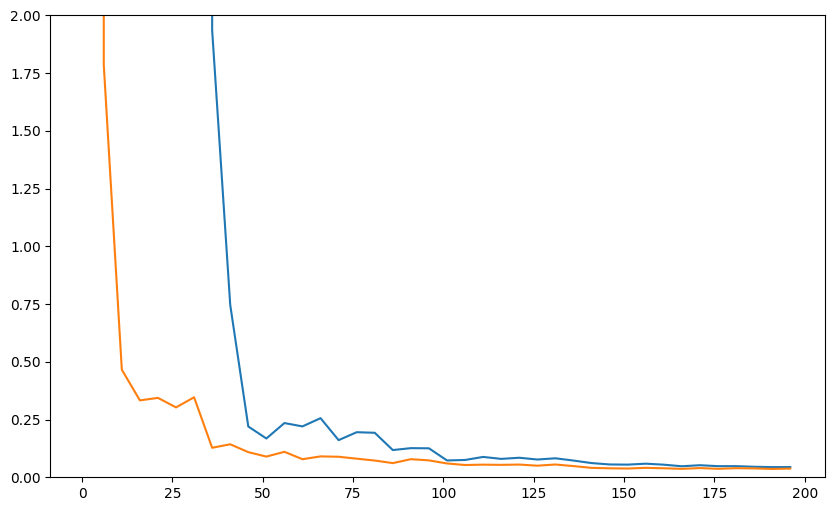

In [ ]:
'''
DR+CE
'''

T = 5
N = 200
sigma_u = 1.0
sigma_w = 1.0
# A_true = jnp.array([[1.01, 0.01, 0, 0, 0], [0.01, 1.01, 0.01, 0, 0], [0, 0.01, 1.01, 0.01, 0], [0, 0, 0.01, 1.01, 0.01], [0, 0, 0, 0.01, 1.01]], dtype=jnp.float32)
# A_true = jnp.array([[1.01, 0.01, 0, 0], [0.01, 1.01, 0.01, 0], [0, 0.01, 1.01, 0.01], [0, 0, 0.01, 1.01]])
A_true = jnp.array([[1.01, 0.01, 0], [0.01, 1.01, 0.01], [0, 0.01, 1.01]], dtype=jnp.float32)
B_true = jnp.eye(3)
Q = jnp.eye(3)*1e-3
R = jnp.eye(3)

'''
  For DR, M: number of SGD iterations, eta: learning rate
'''
M = 10000
eta = 0.0005

'''
  Number of trials!
'''
num_iter = 100

all_J_CE_errors = []
all_J_DR_errors = []


all_J_CE_errors, all_J_DR_errors = vmap(single_evaluation, in_axes = (0))(jnp.arange(num_iter))

all_J_CE_errors = np.stack(all_J_CE_errors)
all_J_DR_errors = np.stack(all_J_DR_errors)
CE_error = np.median(all_J_CE_errors, axis=0)
DR_error = np.median(all_J_DR_errors, axis=0)

plt.figure(figsize=(10, 6))

plt.plot(range(1, N+1, 5), CE_error, label='CE Error')
plt.plot(range(1, N+1, 5), DR_error, label='DR Error')
plt.ylim(0,2)

In [ ]:
'''
  RC
'''

# Preallocate the array for errors

rollout_evals = [5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100, 115, 130, 145, 160, 180, 200]

num_iter = 50
# all_J_RC_errors = np.zeros((num_iter, len(rollout_evals)))
for batch in range(8, 11):
  all_J_RC_errors = np.zeros((num_iter, len(rollout_evals)))
  for j in range((batch-1)*num_iter, batch*num_iter):
      print(f"Iteration {j+1}/{num_iter}")
      theta_batch, FI_batch = run_lse(j)  # Assuming run_lse returns NumPy arrays
      dx = int(theta_batch.shape[1]/2)
      A_hat_batch = theta_batch[:, :dx, :]
      B_hat_batch = theta_batch[:, dx:, :]

      n_x = A_hat_batch.shape[1]
      n_u = B_hat_batch.shape[2]
      n_z = n_x + n_u

      '''
        number of samples for scenario approach!
      '''
      num_sample = 30

      Q_np = np.array(Q)
      R_np = np.array(R)

      layer = create_robust_controller_layer(n_x, n_u, n_z, num_sample, Q_np, R_np)

      key = random.PRNGKey(j)

      # Compute robust controllers for the batch
      K_RC_batch = []
      # K_CE_batch = np.zeros((N, B_hat_batch.shape[1], A_hat_batch.shape[1]))
      for i in rollout_evals:
          print(f"Rollout {i}")
          A_hat = A_hat_batch[i]
          B_hat = B_hat_batch[i]
          FI_hat = FI_batch[i]
          # Sample from the confidence region
          key, subkey = random.split(key)

          # Sample from the confidence region
          A_batch, B_batch = scenario_samples_from_confidence_region(
              A_hat, B_hat, FI_hat, num_sample, i + 1, subkey
          )
          # num_sample = 10
          # A_batch, B_batch = scenario_samples_from_confidence_region(A_hat, B_hat, FI_hat, num_sample, i+1)

          K_RC = robustController(A_batch, B_batch, Q, R, layer)
          if K_RC is None or K_RC.shape != (n_u, n_x):
              # Assign an array of NaNs to indicate infeasibility
              K_RC = jnp.full((n_u, n_x), jnp.nan)
          K_RC_batch.append(K_RC)
          # K_CE = lqr(A_hat, B_hat, Q, R)
          # K_RC_batch[i] = K_RC
          # K_CE_batch[i] = K_CE

      K_RC_batch = np.array(K_RC_batch)

      # Evaluate the controllers
      J_RC_errors = eval_controller_batch(K_RC_batch, A_true, B_true, Q, R)

      # Store the errors
      all_J_RC_errors[j - (batch-1)*50, :] = J_RC_errors

  folder_path = 'drive/My Drive/L4DC 2025 Domain Randomization'
  np.save(folder_path + f'/RC_error_batch_{batch}.npy', all_J_RC_errors)
# RC_error = np.median(all_J_RC_errors, axis=0)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
all_J_CE_errors = np.load('drive/My Drive/L4DC 2025 Domain Randomization/CE_error.npy')

all_DR = []
for i in range(20):
  all_DR.append(np.load(f'drive/My Drive/L4DC 2025 Domain Randomization/DR_error_{i}.npy'))
all_J_DR_errors = np.concatenate(all_DR,axis=0)

In [ ]:
N = 200
RC_evals = [5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100, 115, 130, 145, 160, 180, 200]

all_J_RC_errors = []
for i in range(1, 11):
  all_J_RC_errors.append(np.load(f'drive/My Drive/L4DC 2025 Domain Randomization/RC_error_batch_{i}.npy'))
all_J_RC_errors = np.concatenate(all_J_RC_errors,axis=0)

CE_error = np.median(all_J_CE_errors, axis=0)
DR_error = np.median(all_J_DR_errors, axis=0)
RC_error = np.median(all_J_RC_errors, axis=0)

<ipython-input-5-eb87175202f5>:32: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0.00, 10**1)


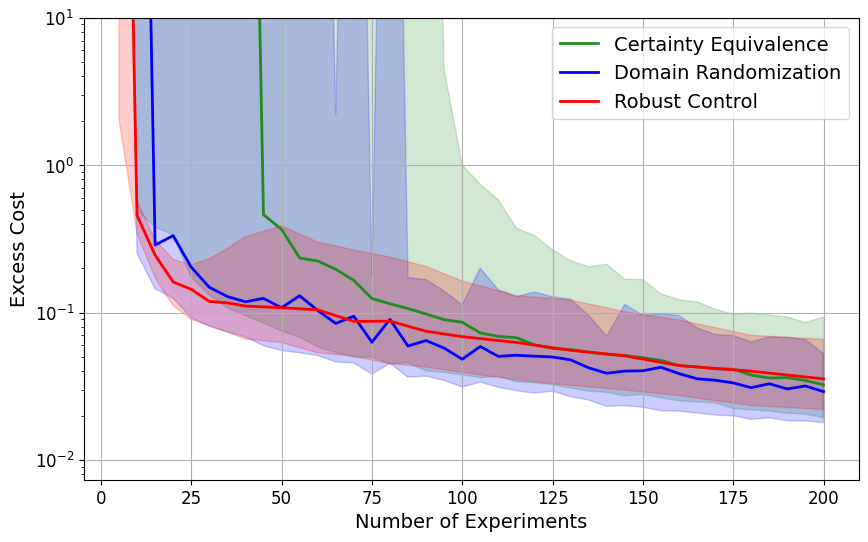

In [ ]:
# num_iter = 10, dim3, A=[1.01, 0.01], num_sample = 30, rollout=150

plt.figure(figsize=(10, 6))

plt.plot(range(5, N+5, 5), CE_error, label='Certainty Equivalence', linewidth=2, color = 'forestgreen')
plt.plot(range(5, N+5, 5), DR_error, label='Domain Randomization', linewidth=2, color='blue')
plt.plot(RC_evals, RC_error, label='Robust Control',linewidth=2, color='red')
# plt.plot(range(1, N+1), CE_error*range(1, N+1), label='CE Error')
# plt.plot(range(1, N+1), DR_error*range(1, N+1), label='DR Error')
# plt.plot(range(1, N+1), RC_error*range(1, N+1), label='RC Error')

# Calculate the 25% quantile of the variation for the error bar
lower_quantile = np.quantile(all_J_CE_errors, 0.25, axis=0)
upper_quantile = np.quantile(all_J_CE_errors, 0.75, axis=0)
plt.fill_between(range(5, N+5, 5), lower_quantile, upper_quantile, alpha=0.2, color='forestgreen')

lower_quantile_DR = np.quantile(all_J_DR_errors, 0.25, axis=0)
upper_quantile_DR = np.quantile(all_J_DR_errors, 0.75, axis=0)
plt.fill_between(range(5, N+5, 5), lower_quantile_DR, upper_quantile_DR, alpha=0.2, color='blue')

lower_quantile_RC = np.quantile(all_J_RC_errors, 0.25, axis=0)
upper_quantile_RC = np.quantile(all_J_RC_errors, 0.7, axis=0)
plt.fill_between(RC_evals, lower_quantile_RC, upper_quantile_RC, alpha=0.2, color='red')


plt.xlabel('Number of Experiments', fontsize=14)
plt.ylabel('Excess Cost', fontsize=14)
# plt.title('CE Error with Error Bar')
# plt.ylim(0, 10)
plt.yscale('log')
plt.grid(True)
plt.ylim(0.00, 10**1)
ax = plt.gca()
plt.legend(fontsize=14)

# Adjust tick font sizes
ax = plt.gca()  # Get the current axis
ax.tick_params(axis='both', which='major', labelsize=12)  # Major ticks
ax.tick_params(axis='both', which='minor', labelsize=10)  # Minor ticks
# plt.grid(True)



plt.savefig('EC_comparison.pdf', bbox_inches='tight')

plt.show()

In [ ]:
'''
#   To concanete CE, DR, RC
# '''
# all_CE_errors = np.load('CE_error.npy')
# all_DR_errors = np.load('DR_error.npy')
# all_RC_errors = np.load('RC_error.npy')

# CE_error = np.median(all_CE_errors, axis=0)
# DR_error = np.median(all_DR_errors, axis=0)
# RC_error = np.median(all_RC_errors, axis=0)


# plt.figure(figsize=(10, 6))

# plt.plot(range(1, N+1, 5), CE_error, label='CE Error')
# plt.plot(range(1, N+1, 5), DR_error, label='DR Error')
# plt.plot(range(1, N+1, 5), RC_error, label='RC Error')

# # Calculate the 25% quantile of the variation for the error bar
# lower_quantile = np.quantile(all_J_CE_errors, 0.375, axis=0)
# upper_quantile = np.quantile(all_J_CE_errors, 0.625, axis=0)
# plt.fill_between(range(1, N+1, 5), lower_quantile, upper_quantile, alpha=0.3, label='CE 25% Quantile Variation')

# lower_quantile_DR = np.quantile(all_J_DR_errors, 0.375, axis=0)
# upper_quantile_DR = np.quantile(all_J_DR_errors, 0.625, axis=0)
# plt.fill_between(range(1, N+1, 5), lower_quantile_DR, upper_quantile_DR, alpha=0.3, label='DR 25% Quantile Variation')

# lower_quantile_RC = np.quantile(all_J_RC_errors, 0.375, axis=0)
# upper_quantile_RC = np.quantile(all_J_RC_errors, 0.625, axis=0)
# plt.fill_between(range(1, N+1, 5), lower_quantile_RC, upper_quantile_RC, alpha=0.3, label='RC 25% Quantile Variation')


# plt.xlabel('Rollouts')
# plt.ylabel('Cost Error')
# # plt.title('CE Error with Error Bar')
# # plt.ylim(0, 10)
# plt.yscale('log')
# plt.ylim(0.00, 10**1)
# ax = plt.gca()
# plt.legend()
# # plt.grid(True)
# plt.show()